In [1]:
install.packages("doParallel")
install.packages("mvtnorm")
install.packages("spikeslab")
library("spikeslab")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lars’, ‘randomForest’


Loading required package: lars

Loaded lars 1.2


Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: parallel


 spikeslab 1.1.5 
 
 Type spikeslab.news() to see new features, changes, and bug fixes. 
 




### Spike and Slab Model

In [ ]:
#' Spike-and-Slab Regression using Gibbs Sampling for p > 1 predictors
#'
#' @param y: vector of responses
#' @param X: matrix of predictor values
#' @param nr_samples: indicates number of samples drawn
#' @param a1: parameter a1 of Gamma prior on variance sigma2e
#' @param a2: parameter a2 of Gamma prior on variance sigma2e
#' @param theta: parameter of prior over mixture weight
#' @param burnin: number of samples we discard ('burnin samples')
#'
#' @returns matrix of posterior samples from parameters pi, beta, tau2, sigma2e, theta
ss_regress <- function(
  y, X, a1 = .01, a2 = .01, theta = .5,
  a = 1, b = 1, s = 1/2, nr_samples = 6000, nr_burnin = round(nr_samples / 4, 2)
  ) {
  
  p <- ncol(X)
  n <- nrow(X)
  
  # res is where we store the posterior samples
  res <- matrix(NA, nrow = nr_samples, ncol = 2*p + 1 + 1 + 1)
  
  colnames(res) <- c(
    paste0('pi', seq(p)),
    paste0('beta', seq(p)),
    'sigma2', 'tau2', 'theta'
  )
  
  # take the MLE estimate as the values for the first sample
  m <- lm(y ~ X - 1)
  res[1, ] <- c(rep(0, p), coef(m), var(predict(m) - y), 1, .5)
  
  # compute only once
  XtX <- t(X) %*% X
  Xty <- t(X) %*% y
  
  # we start running the Gibbs sampler
  for (i in seq(2, nr_samples)) {
    
    # first, get all the values of the previous time point
    pi_prev <- res[i-1, seq(p)]
    beta_prev <- res[i-1, seq(p + 1, 2*p)]
    sigma2_prev <- res[i-1, ncol(res) - 2]
    tau2_prev <- res[i-1, ncol(res) - 1]
    theta_prev <- res[i-1, ncol(res)]
    
    ## Start sampling from the conditional posterior distributions
    ##############################################################
    
    # sample theta from a Beta
    theta_new <- rbeta(1, a + sum(pi_prev), b + sum(1 - pi_prev))
    
    # sample sigma2e from an Inverse-Gamma
    err <- y - X %*% beta_prev
    sigma2_new <- 1 / rgamma(1, a1 + n/2, a2 + t(err) %*% err / 2)
    
    # sample tau2 from an Inverse Gamma
    tau2_new <- 1 / rgamma(
      1, 1/2 + 1/2 * sum(pi_prev),
      s^2/2 + t(beta_prev) %*% beta_prev / (2*sigma2_new)
    )
    
    # sample beta from multivariate Gaussian
    beta_cov <- qr.solve((1/sigma2_new) * XtX + diag(1/(tau2_new*sigma2_new), p))
    beta_mean <- beta_cov %*% Xty * (1/sigma2_new)
    beta_new <- mvtnorm::rmvnorm(1, beta_mean, beta_cov)
    
    # sample each pi_j in random order
    for (j in sample(seq(p))) {
      
      # get the betas for which beta_j is zero
      pi0 <- pi_prev
      pi0[j] <- 0
      bp0 <- t(beta_new * pi0)
      
      # compute the z variables and the conditional variance
      xj <- X[, j]
      z <- y - X %*% bp0
      cond_var <- sum(xj^2) + 1/tau2_new
      
      # compute chance parameter of the conditional posterior of pi_j (Bernoulli)
      l0 <- log(1 - theta_new)
      l1 <- (
        log(theta_new) - .5 * log(tau2_new*sigma2_new) +
        sum(xj*z)^2 / (2*sigma2_new*cond_var) + .5 * log(sigma2_new / cond_var)
      )
      
      # sample pi_j from a Bernoulli
      pi_prev[j] <- rbinom(1, 1, exp(l1) / (exp(l1) + exp(l0)))
    }
    
    pi_new <- pi_prev
    
    # add new samples
    res[i, ] <- c(pi_new, beta_new*pi_new, sigma2_new, tau2_new, theta_new)
  }
  
  # remove the first nr_burnin number of samples
  res[-seq(nr_burnin), ]
}

In [ ]:
library('doParallel')
registerDoParallel(cores = 4)
 
#' Calls the ss_regress function in parallel
#' 
#' @params same as ss_regress
#' @params nr_cores: numeric, number of cores to run ss_regress in parallel
#' @returns a list with nr_cores entries which are posterior samples
ss_regressm <- function(
  y, X, a1 = .01, a2 = .01, theta = .5,
  a = 1, b = 1, s = 1/2, nr_samples = 6000,
  nr_burnin = round(nr_samples / 4, 2), nr_cores = 4
  ) {
  
  samples <- foreach(i = seq(nr_cores), .combine = rbind) %dopar% {
    ss_regress(
      y = y, X = X, a1 = a1, a2 = a2, theta = theta,
      a = a, b = b, s = s, nr_samples = nr_samples,
      nr_burnin = nr_burnin
    )
  }
  
  samples
}

Loading required package: foreach

Loading required package: iterators



###variable selection of hartmann6

In [2]:
X0 = read.csv(url("https://raw.githubusercontent.com/chuckwong13/Bayesian_global_optimization/master/Data/X_hartmann.csv"))
Y0 = read.csv(url("https://raw.githubusercontent.com/chuckwong13/Bayesian_global_optimization/master/Data/Y_hartmann.csv"))

X0$X <- NULL
Y0$X <- NULL
head(X0)
head(Y0)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8948671,0.41574809,0.1102465,0.3124976,0.1703351,0.9857423,0.3665172,0.6870528,0.42016631,0.01441573
2,0.7119538,0.86055386,0.4635507,0.5635753,0.3743506,0.1030219,0.2027229,0.1308678,0.88867688,0.43573099
3,0.3113835,0.16691336,0.6487751,0.1876138,0.5069059,0.5405686,0.5408617,0.9079411,0.03394331,0.79904008
4,0.4896521,0.98609579,0.1986522,0.8231373,0.3815578,0.7073063,0.8038440,0.5898206,0.67035460,0.25039199
5,0.5182739,0.04112732,0.8843954,0.4490987,0.7489644,0.1452498,0.4544824,0.3713399,0.25263295,0.88708901
6,0.8436432,0.73688346,0.5350019,0.6767815,0.7966654,0.7623469,0.1031687,0.8181476,0.78413165,0.55915707


,y
,<dbl>
1,-0.182834129
2,-0.602555516
3,-1.478205241
4,-0.013030171
5,-0.014180491
6,-0.002242497


In [ ]:
set.seed(111)
obj <- spikeslab(x=data.matrix(X0),y=data.matrix(Y0))
# obj <- spikeslab(x=Xz,y=yz)
print(obj)

------------------------------------------------------------------- 
Variable selection method     : AIC 
Big p small n                 : FALSE 
Screen variables              : FALSE 
Fast processing               : TRUE 
Sample size                   : 2000 
No. predictors                : 10 
No. burn-in values            : 500 
No. sampled values            : 500 
Estimated mse                 : 0.1262 
Model size                    : 7 


---> Top variables:
      bma   gnet bma.scale gnet.scale
x0  0.099  0.098     0.342      0.340
x4  0.092  0.091     0.318      0.317
x3  0.070  0.069     0.241      0.240
x1  0.009  0.009     0.031      0.031
x2 -0.008 -0.009    -0.026     -0.031
x7  0.007  0.006     0.023      0.022
x5  0.003  0.004     0.012      0.012
------------------------------------------------------------------- 


------------------------------------------------------------------- 
Variable selection method     : cross-validation 
Big p small n                 : FALSE 
Screen variables              : FALSE 
Fast processing               : TRUE 
Sample size                   : 2000 
No. predictors                : 10 
No. burn-in values            : 500 
No. sampled values            : 500 
K-fold                        : 20 
CV mean-squared error         : 0.127 +/- 0.009 
Model size                    : [4,8] 


Top variables in terms of stability:
      bma bma.cv   gnet gnet.cv stability
x0  0.099  0.099  0.098   0.098       100
x4  0.092  0.092  0.091   0.091       100
x3  0.070  0.070  0.069   0.069       100
x1  0.008  0.008  0.009   0.008        90
x2 -0.008 -0.008 -0.009  -0.009        85
x7  0.006  0.006  0.006   0.006        80
x5  0.004  0.004  0.004   0.004        70
------------------------------------------------------------------- 


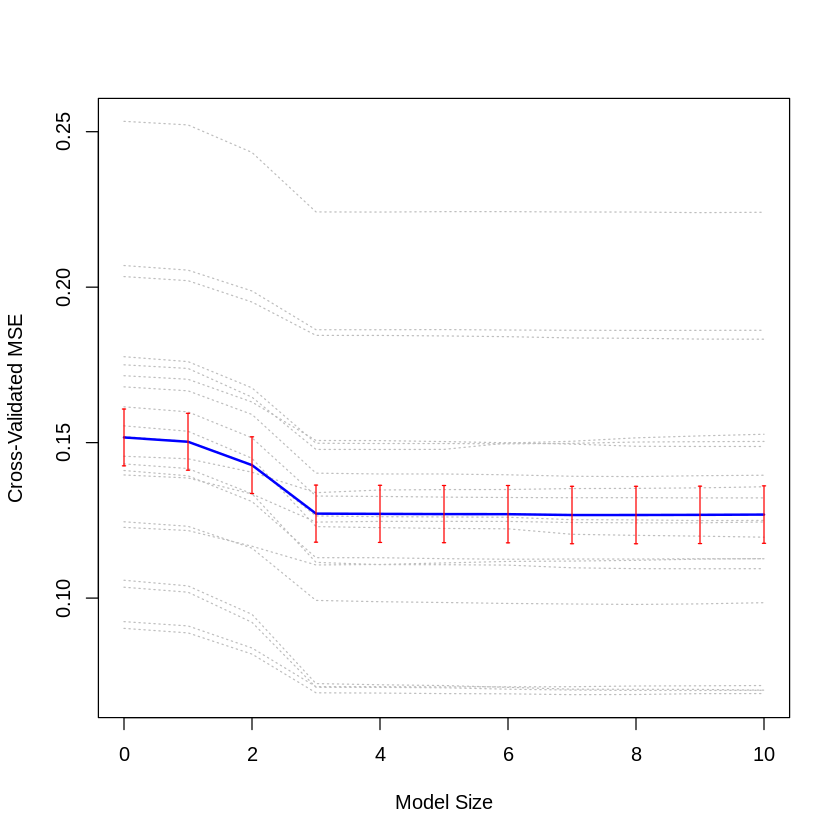

In [3]:
set.seed(111)
cv.obj <- cv.spikeslab(x = data.matrix(X0), y = data.matrix(Y0), K = 20)

In [ ]:
  std <- function(x) (x - mean(x)) / sd(x)
  
  yz <- apply(Y0, 2, std)
  Xz <- apply(X0, 2, std)
  
  samples <- ss_regressm(
    y = data.matrix(Y0), X = data.matrix(X0), a1 = .01, a2 = .01,
    a = 1, b = 1, s = 1/2, nr_cores = 4, nr_samples = 4000
  )
  
  post_means <- apply(samples, 2, mean)
  
  res_table <- cbind(
    post_means[grepl('beta', names(post_means))],
    post_means[grepl('pi', names(post_means))]
  )
  rownames(res_table) <- colnames(Xz)
  colnames(res_table) <- c('Post. Mean', 'Post. Inclusion')
  
  round(res_table, 3)

,Post. Mean,Post. Inclusion
x0,0.201,1.000
x1,-0.098,0.999
x2,-0.191,1.000
x3,0.101,1.000
x4,0.176,1.000
x5,-0.116,1.000
x6,-0.136,1.000
x7,-0.109,1.000
x8,-0.158,1.000
x9,-0.140,1.000


### variable selection for CNN

In [6]:
X = read.csv(url("https://raw.githubusercontent.com/chuckwong13/Bayesian_global_optimization/master/Data/X.csv"))
Y = read.csv(url("https://raw.githubusercontent.com/chuckwong13/Bayesian_global_optimization/master/Data/Y.csv"))

X$X <- NULL
Y$X <- NULL
head(X)
head(Y)

,beta1,beta2,eps,lr,num_epochs,weight_decay
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.361301559,0.17062872,4.090840e-09,0.007396255,11,0.07426800
2,0.006541205,0.94218230,7.568320e-09,0.034813137,4,0.13014743
3,0.833775316,0.38146586,1.213175e-09,0.002779586,12,0.17103977
4,0.478842188,0.57735907,9.814373e-09,0.001101594,14,0.08089282
5,0.681708954,0.01273989,1.467046e-09,0.087880419,2,0.22029589
6,0.950370876,0.84892649,5.489565e-09,0.016259449,9,0.27606550


,acc
,<dbl>
1,0.97883333
2,0.09116667
3,0.97916667
4,0.97766667
5,0.10983333
6,0.97550000


In [ ]:
obj <- spikeslab(x=data.matrix(X),y=data.matrix(Y))
print(obj)

------------------------------------------------------------------- 
Variable selection method     : AIC 
Big p small n                 : FALSE 
Screen variables              : FALSE 
Fast processing               : TRUE 
Sample size                   : 500 
No. predictors                : 6 
No. burn-in values            : 500 
No. sampled values            : 500 
Estimated mse                 : 0.0366 
Model size                    : 5 


---> Top variables:
                bma   gnet bma.scale gnet.scale
lr           -0.148 -0.149    -6.572     -6.601
beta1        -0.043 -0.043    -0.148     -0.150
beta2         0.038  0.038     0.132      0.133
num_epochs    0.022  0.021     0.005      0.005
weight_decay  0.010  0.011     0.118      0.123
------------------------------------------------------------------- 


------------------------------------------------------------------- 
Variable selection method     : cross-validation 
Big p small n                 : FALSE 
Screen variables              : FALSE 
Fast processing               : TRUE 
Sample size                   : 500 
No. predictors                : 6 
No. burn-in values            : 500 
No. sampled values            : 500 
K-fold                        : 20 
CV mean-squared error         : 0.037 +/- 0.004 
Model size                    : [4,6] 


Top variables in terms of stability:
                bma bma.cv   gnet gnet.cv stability
lr           -0.148 -0.148 -0.149  -0.133        95
beta1        -0.043 -0.043 -0.043  -0.033        85
beta2         0.038  0.038  0.038   0.029        80
num_epochs    0.022  0.021  0.021   0.016        80
weight_decay  0.010  0.010  0.011   0.007        65
------------------------------------------------------------------- 


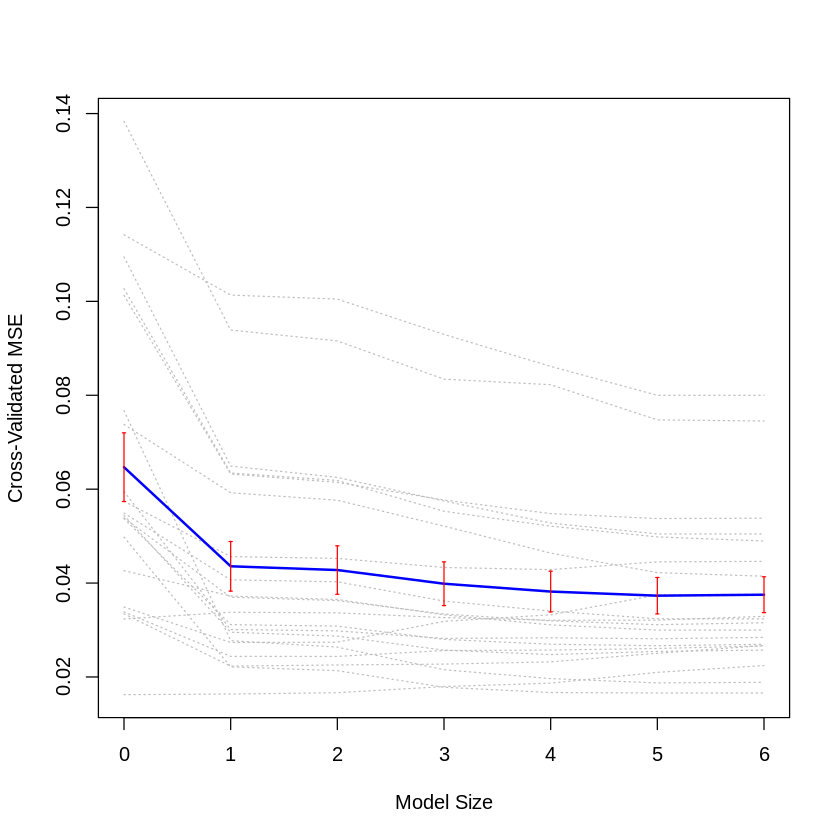

In [7]:
set.seed(111)
cv.obj <- cv.spikeslab(x = data.matrix(X), y = data.matrix(Y), K = 20)

In [ ]:
  std <- function(x) (x - mean(x)) / sd(x)
  
  yz <- apply(Y, 2, std)
  Xz <- apply(X, 2, std)
  
  samples <- ss_regressm(
    y = yz, X = Xz, a1 = .01, a2 = .01,
    a = 1, b = 1, s = 1/2, nr_cores = 4, nr_samples = 4000
  )
  
  post_means <- apply(samples, 2, mean)
  
  res_table <- cbind(
    post_means[grepl('beta', names(post_means))],
    post_means[grepl('pi', names(post_means))]
  )
  rownames(res_table) <- colnames(Xz)
  colnames(res_table) <- c('Post. Mean', 'Post. Inclusion')
  
  round(res_table, 3)

,Post. Mean,Post. Inclusion
beta1,-0.181,1.000
beta2,0.163,1.000
eps,-0.004,0.301
lr,-0.593,1.000
num_epochs,0.087,0.912
weight_decay,0.029,0.534
